Detect likely contamination sources in a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. The system uses Bayesian optimisation to tune detection parameters and reliably identify both strong and weak sources.

In [5]:
import numpy as np
import pandas as pd


In [6]:
inputs_f1 = np.load('function_1/initial_inputs.npy')
outputs_f1 = np.load('function_1/initial_outputs.npy')

In [7]:
print("Inputs (Function 1):", inputs_f1)

Inputs (Function 1): [[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]]


In [8]:
print("Outputs (Function 1):", outputs_f1)

Outputs (Function 1): [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048]


Visualzing inouts 

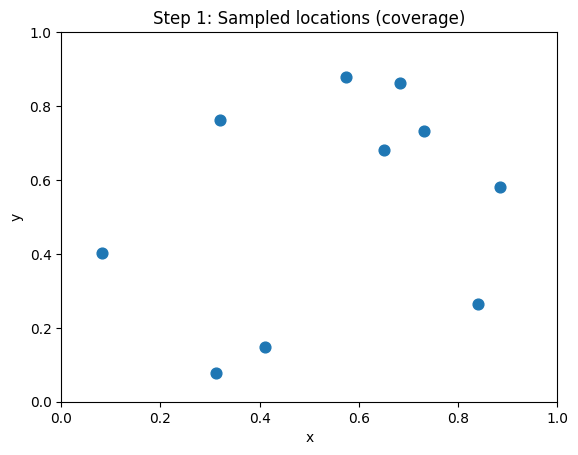

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(inputs_f1[:, 0], inputs_f1[:, 1], s=60)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Step 1: Sampled locations (coverage)")
plt.show()

Visualizing outputs

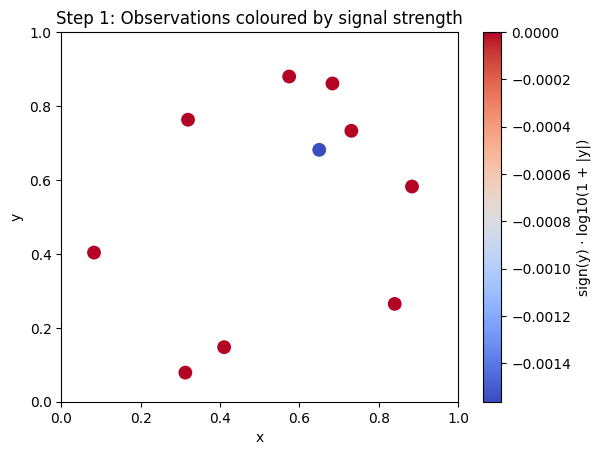

In [10]:
y_vis = np.sign(outputs_f1) * np.log10(1 + np.abs(outputs_f1))
plt.figure()
sc = plt.scatter(
    inputs_f1[:, 0],
    inputs_f1[:, 1],
    c=y_vis,
    s=80,
    cmap='coolwarm'
)
plt.colorbar(sc, label="sign(y) · log10(1 + |y|)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Step 1: Observations coloured by signal strength")
plt.show()


In [11]:
y_transformed = np.sign(outputs_f1) * np.log1p(np.abs(outputs_f1))

Initialize the Gausian process

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = (
    1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 1.0))
    + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e-2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

In [13]:
gp.fit(inputs_f1, y_transformed)

/opt/homebrew/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.2) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

In [14]:
print(gp.kernel_)

1**2 * RBF(length_scale=0.01) + WhiteKernel(noise_level=5e-05)


In [15]:
grid_size = 100
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
Xg, Yg = np.meshgrid(x, y)

X_grid = np.column_stack([Xg.ravel(), Yg.ravel()])

In [16]:
mu, sigma = gp.predict(X_grid, return_std=True)

mu = mu.reshape(grid_size, grid_size)
sigma = sigma.reshape(grid_size, grid_size)
print(mu)
print(sigma)

[[-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]
 [-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]
 [-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]
 ...
 [-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]
 [-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]
 [-0.00035996 -0.00035996 -0.00035996 ... -0.00035996 -0.00035996
  -0.00035996]]
[[0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]
 [0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]
 [0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]
 ...
 [0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]
 [0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]
 [0.00107987 0.00107987 0.00107987 ... 0.00107987 0.00107987 0.00107987]]


identifying hte best observed point

In [18]:
idx_best = np.argmin(outputs_f1)  # assuming lower = stronger contamination
x_best = inputs_f1[idx_best]
x_best

array([0.65011406, 0.68152635])

Combined plot with both mu and sigma

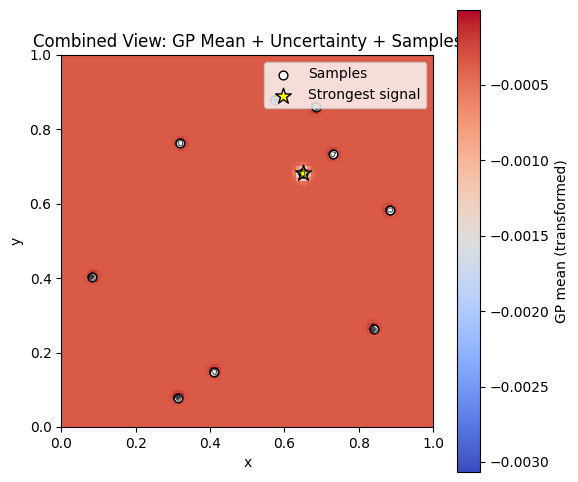

In [19]:
plt.figure(figsize=(6,6))

# GP mean as background
plt.imshow(
    mu,
    origin='lower',
    extent=(0,1,0,1),
    aspect='equal',
    cmap='coolwarm'
)
plt.colorbar(label="GP mean (transformed)")

# GP uncertainty as contours
levels = np.linspace(np.min(sigma), np.max(sigma), 6)
plt.contour(
    Xg, Yg, sigma,
    levels=levels,
    colors='black',
    linewidths=0.8,
    alpha=0.7
)

# Sampled points
plt.scatter(
    inputs_f1[:,0],
    inputs_f1[:,1],
    c='white',
    s=40,
    edgecolors='black',
    label='Samples'
)

# Best point
plt.scatter(
    x_best[0],
    x_best[1],
    c='yellow',
    s=140,
    marker='*',
    edgecolors='black',
    label='Strongest signal'
)

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Combined View: GP Mean + Uncertainty + Samples")
plt.show()

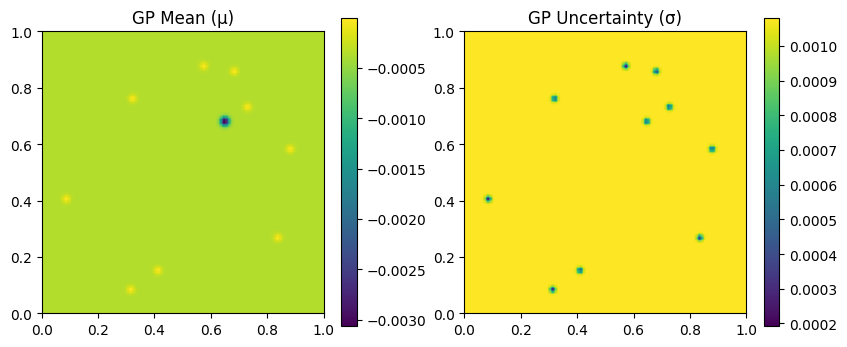

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(mu, origin='lower', extent=(0,1,0,1), aspect='equal')
plt.title("GP Mean (μ)")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(sigma, origin='lower', extent=(0,1,0,1), aspect='equal')
plt.title("GP Uncertainty (σ)")
plt.colorbar()

plt.show()

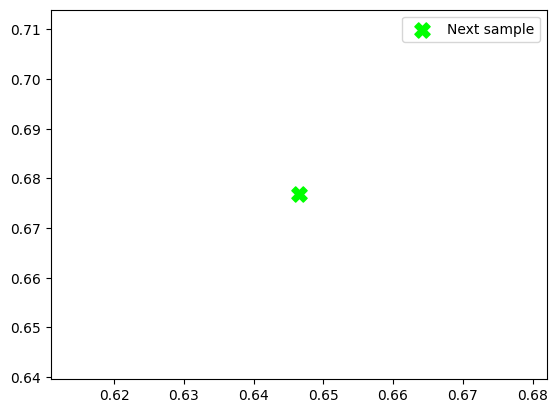

Next sampling location (Function 1): [0.64646465 0.67676768]


In [23]:
UCB = mu + 2.5 * sigma
idx_next = np.argmin(UCB)
x_next = X_grid[idx_next]

plt.scatter(
    x_next[0],
    x_next[1],
    c='lime',
    s=120,
    marker='X',
    label='Next sample'
)
plt.legend()
plt.show()
print("Next sampling location (Function 1):", x_next)